## 1. Importing Neccessary Libraries

In [1]:
import torch
from torch import nn
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

import torchmetrics, mlxtend

mlxtend.__version__
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix


## 2. Loading Training and Test Dataset

In [2]:
#train data
train_data = datasets.FashionMNIST(
    root = "data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

In [3]:
#Test Data
test_data = datasets.FashionMNIST(
    root = "data",
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

In [4]:
#number of rows for train and test data
print(f"Total training: {len(train_data)}, Total test: {len(test_data)}")

Total training: 60000, Total test: 10000


## 3. Sampling Dataset

In [5]:
#set training sample
image, label = train_data[0]

In [6]:
#getting names of classes
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [7]:
#getting class names and their IDs
class_to_idx = train_data.class_to_idx
class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [8]:
print(f"Image Shape: {image.shape} -> [color_channel, height, width] ")
print(f"Iamge LAbel: {class_names[label]}")

Image Shape: torch.Size([1, 28, 28]) -> [color_channel, height, width] 
Iamge LAbel: Ankle boot


### Visualising data sample

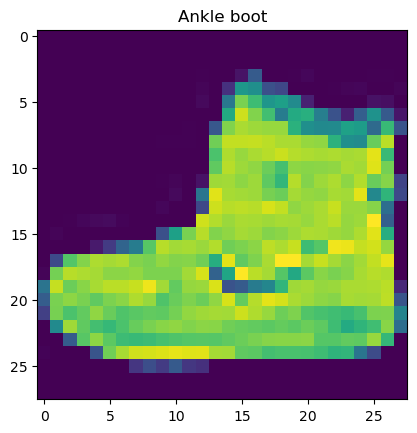

In [9]:
plt.title(class_names[label])
plt.imshow(image.squeeze())


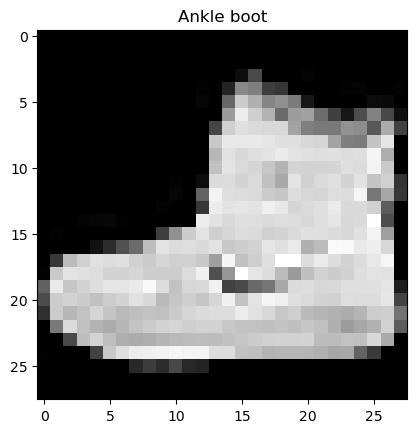

In [10]:
# returning sample but in grey
plt.title(class_names[label])
plt.imshow(image.squeeze(), cmap="gray")


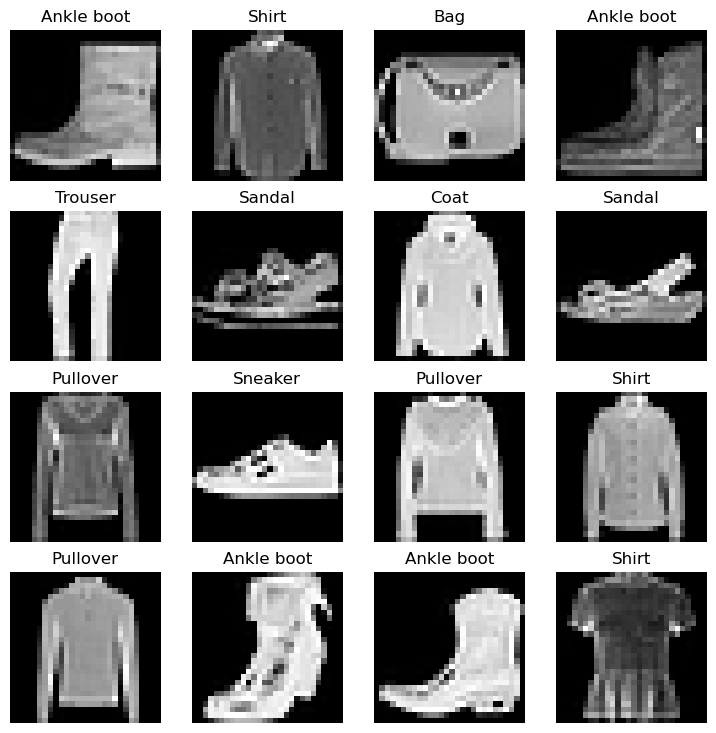

In [11]:
torch.manual_seed(42)
fig = plt.figure(figsize=(9,9))
rows,col = 4, 4
for i in range(1, rows*col+1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows,col, i)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(class_names[label])
    plt.axis(False)
    
    

## Preparing DataLoader

In [12]:
from torch.utils.data import DataLoader

#setting hyper parameters
BATCH_SIZE = 32
train_dataloader = DataLoader(dataset=train_data,
                              batch_size= BATCH_SIZE,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False)


In [13]:
print(f"DataLoader : {train_dataloader}, {test_dataloader}")
print(f"length of train DataLoader : {len(train_dataloader)}, {BATCH_SIZE}")
print(f"length of test DataLoader : {len(test_dataloader)}, {BATCH_SIZE}")

DataLoader : <torch.utils.data.dataloader.DataLoader object at 0x7f8360f5cc10>, <torch.utils.data.dataloader.DataLoader object at 0x7f8360f5cb50>
length of train DataLoader : 1875, 32
length of test DataLoader : 313, 32


In [14]:
train_features_batch, train_labels_batch =next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

Image Size: torch.Size([1, 28, 28])


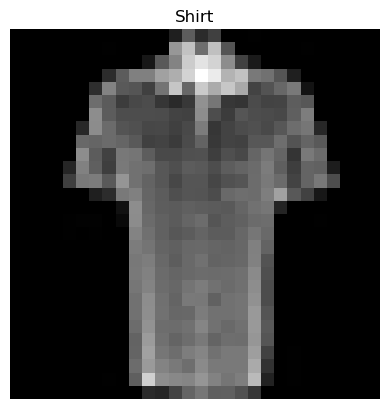

In [15]:
#show a sample
torch.manual_seed(42)
random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
img, label = train_features_batch[random_idx], train_labels_batch[random_idx]
plt.imshow(img.squeeze(), cmap="gray")
plt.title(class_names[label])
plt.axis(False)
print(f"Image Size: {img.shape}")


## 3. DEFINING FUNCTIONS FOR TRAINIG, TESTING, EVALUATING MODEL

In [16]:
def accuracy_fn(y_true: torch.Tensor, y_pred: torch.Tensor):
    """
    Calculates the accuracy between true labels and predicted labels.

    Args:
        y_true (torch.Tensor): Ground truth labels.
        y_pred (torch.Tensor): Predicted labels.

    Returns:
        float: Accuracy percentage.
    """
    correct = torch.eq(y_true, y_pred).sum().item()  # Count correctly predicted samples
    acc = (correct / len(y_pred)) * 100  # Compute accuracy percentage
    return acc


In [17]:
from timeit import default_timer as timer  # More precise timing

def print_train_time(start: float,
                     end: float,
                     device: torch.device = None):
    """ 
    Calculates and prints the training duration.

    Args:
        start (float): The starting time (e.g., from `timeit.default_timer()`).
        end (float): The ending time.
        device (torch.device, optional): The device (CPU/GPU) where training was performed.

    Returns:
        float: The total elapsed time in seconds.
    """
    
    total_time = end - start  # Compute elapsed time
    print(f"Train time on device {device}: {total_time:.3f} seconds")
    
    return total_time  # Return total time for logging if needed


In [18]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimiser: torch.optim.Optimizer,
               accuracy_fn):
    """
    Performs a single training loop over the dataset.

    Args:
        model (torch.nn.Module): The neural network model to train.
        data_loader (torch.utils.data.DataLoader): The training dataset loader.
        loss_fn (torch.nn.Module): The loss function to compute training loss.
        optimiser (torch.optim.Optimizer): The optimizer used for updating model parameters.
        accuracy_fn (function): A function to compute training accuracy.

    Returns:
        None: Prints the average training loss and accuracy.
    """
    
    train_loss, train_acc = 0, 0  # Initialize training loss and accuracy
  
    for batch, (X, y) in enumerate(data_loader):  # Iterate through training batches
        
        y_pred = model(X)  # Forward pass: Get model predictions
        
        loss = loss_fn(y_pred, y)  # Compute loss
        train_loss += loss  # Accumulate loss
        
        train_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))  # Compute and accumulate accuracy
        
        optimiser.zero_grad()  # Reset gradients before backpropagation
        
        loss.backward()  # Backpropagation: Compute gradients
        
        optimiser.step()  # Update model parameters using optimizer
    
    # Compute average loss and accuracy
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")


In [19]:
def test_step(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              accuracy_fn):
    """
    Performs the testing loop for a given model.

    Args:
        model (torch.nn.Module): The trained model to evaluate.
        data_loader (torch.utils.data.DataLoader): The test dataset loader.
        loss_fn (torch.nn.Module): The loss function to compute test loss.
        accuracy_fn (function): A function to compute test accuracy.

    Returns:
        None: Prints the test loss and accuracy.
    """
    test_loss, test_acc = 0, 0  # Initialize test loss and accuracy

    model.eval()  # Set the model to evaluation mode (disables dropout, batch norm updates)
    
    with torch.inference_mode():  # Disable gradient calculations for efficiency
        for X_test, y_test in data_loader:  # Iterate through test batches
            test_pred = model(X_test)  # Forward pass: get model predictions
            
            test_loss += loss_fn(test_pred, y_test)  # Compute and accumulate loss
            
            # Compute and accumulate accuracy
            test_acc += accuracy_fn(y_true=y_test, 
                                    y_pred=test_pred.argmax(dim=1)) 
        
        # Compute average test loss and accuracy
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        
    print(f"Test loss: {test_loss:.4f}, test acc: {test_acc:.2f}%")


In [20]:
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn):
    """
    Evaluates a trained model on a given dataset.

    Args:
        model (torch.nn.Module): The trained model to evaluate.
        data_loader (torch.utils.data.DataLoader): The dataset loader (test/validation).
        loss_fn (torch.nn.Module): The loss function to compute loss.
        accuracy_fn (function): Function to calculate accuracy.

    Returns:
        dict: A dictionary containing model name, average loss, and accuracy.
    """

    loss, acc = 0, 0  # Initialize loss and accuracy counters
    model.eval()  # Set model to evaluation mode (disables dropout, batch norm updates)
    
    with torch.inference_mode():  # Disable gradient tracking for efficiency
        for X, y in data_loader:  # Iterate through dataset
            
            y_pred = model(X)  # Forward pass
            
            loss += loss_fn(y_pred, y)  # Compute and accumulate loss
            acc += accuracy_fn(y, y_pred.argmax(dim=1))  # Compute and accumulate accuracy
        
        # Compute average loss and accuracy
        loss /= len(data_loader)
        acc /= len(data_loader)
    
    return {
        "Model Name": model.__class__.__name__, 
        "Model Loss": loss.item(),  # Convert loss to a scalar value
        "Model Accuracy": acc
    }


## 4. CREATING BASELINE MODEL

In [21]:
#create a flatten layer
flatten_model = nn.Flatten()

#getting a single sample
x = train_features_batch[0]
x.shape


output = flatten_model(x)

print(f"Before flattening: {x.shape}")
print(f"After flattening: {output.shape}")

Before flattening: torch.Size([1, 28, 28])
After flattening: torch.Size([1, 784])


In [22]:
class FashionModelV_0(nn.Module):
    """
    A simple feedforward neural network for classifying fashion items.

    Args:
        input_shape (int): Number of input features (e.g., 28x28 for FashionMNIST).
        hidden_unit (int): Number of neurons in the hidden layer.
        output_shape (int): Number of output classes.

    Layers:
        - Flatten: Converts input images to a 1D tensor.
        - Linear 1: Fully connected layer transforming inputs to hidden units.
        - Linear 2: Fully connected layer transforming hidden units to output classes.

    Forward Pass:
        - Passes input through the stacked layers.

    Returns:
        torch.Tensor: Model predictions.
    """

    def __init__(self, input_shape: int, hidden_unit: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),  # Flattens input (e.g., 28x28 -> 784)
            nn.Linear(in_features=input_shape, out_features=hidden_unit),  # Hidden layer
            nn.Linear(in_features=hidden_unit, out_features=output_shape)  # Output layer
        )

    def forward(self, x):
        return self.layer_stack(x)  # Forward pass through the network

In [23]:
model_0 = FashionModelV_0(input_shape=784, #i.e 28 * 28
                          hidden_unit=10,
                          output_shape= len(class_names))
model_0

FashionModelV_0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [24]:
#initialising loss and optimiser functions
loss_fn = nn.CrossEntropyLoss( )

optimiser = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)


In [25]:
torch.manual_seed(42)
 
epochs = 3

for epoch in range(epochs):
    train_step(model=model_0,
               data_loader=train_dataloader,
               loss_fn=loss_fn,
               optimiser=optimiser,
               accuracy_fn=accuracy_fn)
    test_step(model=model_0,
              data_loader=test_dataloader,
              loss_fn=loss_fn,
              accuracy_fn=accuracy_fn)

               

Train Loss: 0.5948 | Train Acc: 78.99%
Test loss: 0.5164, test acc: 81.84%
Train Loss: 0.4795 | Train Acc: 83.12%
Test loss: 0.4814, test acc: 83.18%
Train Loss: 0.4570 | Train Acc: 83.99%
Test loss: 0.4777, test acc: 83.50%


In [26]:
model_0_results = eval_model(model=model_0,
                             data_loader=test_dataloader,
                             loss_fn=loss_fn,
                             accuracy_fn=accuracy_fn)
model_0_results

{'Model Name': 'FashionModelV_0',
 'Model Loss': 0.4777320623397827,
 'Model Accuracy': 83.49640575079871}

In [27]:
import torch
import torch.nn as nn

class FashionModelV_1(nn.Module):
    """
    An improved feedforward neural network for classifying fashion items.

    Args:
        input_shape (int): Number of input features (e.g., 28x28 for FashionMNIST).
        hidden_unit (int): Number of neurons in the hidden layer.
        output_shape (int): Number of output classes.

    Architecture:
        - Flatten: Converts input images to a 1D tensor.
        - Linear 1: Fully connected layer transforming inputs to hidden units.
        - ReLU: Applies non-linearity to introduce learning capacity.
        - Linear 2: Fully connected layer transforming hidden units to output classes.
        - ReLU: Another non-linearity applied to output layer.

    Forward Pass:
        - Passes input through the sequential layers.

    Returns:
        torch.Tensor: Model predictions.
    """

    def __init__(self, input_shape: int, hidden_unit: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),  # Flattens input (e.g., 28x28 -> 784)
            nn.Linear(in_features=input_shape, out_features=hidden_unit),  # Hidden layer
            nn.ReLU(),  # Activation function for non-linearity
            nn.Linear(in_features=hidden_unit, out_features=output_shape),  # Output layer
            nn.ReLU()  # Activation function on output
        )

    def forward(self, x: torch.Tensor): 
        return self.layer_stack(x)  # Forward pass through the network


In [28]:
torch.manual_seed(42)
model_1 = FashionModelV_1(input_shape=784,
                          hidden_unit=10,
                          output_shape=len(class_names),
                          )
model_1

FashionModelV_1(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): ReLU()
    (3): Linear(in_features=10, out_features=10, bias=True)
    (4): ReLU()
  )
)

In [29]:
loss_fn1 = nn.CrossEntropyLoss()

optimiser1 = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.1)

In [30]:
torch.manual_seed(42)
epochs = 3
for epoch in range(epochs):
    train_step(model=model_1,
               data_loader=train_dataloader,
               loss_fn=loss_fn1,
               optimiser = optimiser1,
               accuracy_fn=accuracy_fn)
    test_step(model=model_1,
              data_loader=test_dataloader,
              loss_fn=loss_fn,
              accuracy_fn=accuracy_fn)

Train Loss: 1.0920 | Train Acc: 61.34%
Test loss: 0.9564, test acc: 65.00%
Train Loss: 0.7810 | Train Acc: 71.93%
Test loss: 0.7223, test acc: 73.91%
Train Loss: 0.6703 | Train Acc: 75.94%
Test loss: 0.6850, test acc: 75.02%


In [31]:
# get model results 
model_1_results = eval_model(model=model_1,
                             data_loader=test_dataloader,
                             loss_fn=loss_fn,
                             accuracy_fn=accuracy_fn
                             )
model_1_results

{'Model Name': 'FashionModelV_1',
 'Model Loss': 0.6850008964538574,
 'Model Accuracy': 75.01996805111821}

## Using a Convolutional Neural network

In [32]:
class FashionModel_V2(nn.Module):
    """ 
    Model architecture replicates the TinyVGG architecture for image classification.
    
    The model consists of two convolutional blocks, each with:
    - Two 3x3 convolutional layers followed by ReLU activations.
    - A MaxPool layer to reduce the spatial dimensions of the image.
    
    After the convolutional layers, the model includes a fully connected classifier to predict the class labels.
    
    Args:
        input_shape (int): Number of input channels (for grayscale images like FashionMNIST, this is 1).
        output_shape (int): Number of output classes (e.g., 10 for FashionMNIST).
        hidden_units (int): Number of filters/neurons in each convolutional layer.
    
    Architecture:
        - Conv Block 1:
            - 2 Conv2d layers (3x3 kernels) followed by ReLU activations and a MaxPooling layer.
        - Conv Block 2:
            - 2 Conv2d layers (3x3 kernels) followed by ReLU activations and a MaxPooling layer.
        - Classifier:
            - Flatten input and pass through a fully connected (Linear) layer to output predictions.
    
    Forward Pass:
        - The input passes through the convolutional blocks, followed by the classifier to obtain the predictions.
        
    Returns:
        torch.Tensor: Model's output predictions.
    """

    def __init__(self, input_shape: int, output_shape: int, hidden_units: int):
        super().__init__()
        
        # First convolutional block
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,              # First convolution layer
                      out_channels=hidden_units,           # Number of output channels
                      kernel_size=3,                      # Kernel size of 3x3
                      stride=1,                           # Stride of 1
                      padding=1),                         # Padding of 1 (preserving input size)
            nn.ReLU(),                                  # Activation function
            nn.Conv2d(in_channels=hidden_units,          # Second convolution layer
                      out_channels=hidden_units,         # Same number of output channels
                      kernel_size=3,                     # Kernel size of 3x3
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)                  # MaxPool to reduce the spatial size by 2x2
        )
        
        # Second convolutional block
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,           # First convolution layer
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,           # Second convolution layer
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)                  # MaxPool to further reduce size
        )
        
        # Fully connected classifier (after flattening)
        self.classifier = nn.Sequential(
            nn.Flatten(),                              # Flatten the output from convolution layers into a 1D vector
            nn.Linear(in_features=hidden_units*7*7,    # Fully connected layer (Input size depends on the output size of conv layers)
                      out_features=output_shape)       # Output size corresponds to the number of classes
        )

    def forward(self, x):
        """
        Forward pass through the model.
        
        Args:
            x (torch.Tensor): Input image batch with shape (batch_size, input_channels, height, width).
        
        Returns:
            torch.Tensor: Model's predictions for each input.
        """
        # Pass input through the first convolution block
        x = self.conv_block_1(x)
        
        # Pass input through the second convolution block
        x = self.conv_block_2(x)
        
        # Pass through the fully connected classifier (after flattening)
        x = self.classifier(x)
        
        return x

In [33]:
torch.manual_seed(42)
model_2 = FashionModel_V2(input_shape=1, 
    hidden_units=10, 
    output_shape=len(class_names))
model_2

FashionModel_V2(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [34]:
loss_fn = nn.CrossEntropyLoss()

optimiser = torch.optim.SGD(params=model_2.parameters(), lr=0.1)

In [35]:
torch.manual_seed(42)
epochs = 3
for epoch in range(epochs):
    train_step(model=model_2,
            data_loader=train_dataloader,
            loss_fn=loss_fn,
            optimiser=optimiser,
            accuracy_fn=accuracy_fn)
    test_step(model=model_2, 
              data_loader=test_dataloader,
              loss_fn=loss_fn,
              accuracy_fn=accuracy_fn)

Train Loss: 0.5986 | Train Acc: 78.36%
Test loss: 0.3878, test acc: 86.14%
Train Loss: 0.3581 | Train Acc: 87.14%
Test loss: 0.3506, test acc: 87.06%
Train Loss: 0.3215 | Train Acc: 88.35%
Test loss: 0.3227, test acc: 88.39%


In [36]:
# get model results 
model_2_results = eval_model(model=model_2,
                             data_loader=test_dataloader,
                             loss_fn=loss_fn,
                             accuracy_fn=accuracy_fn
                             )
model_2_results

{'Model Name': 'FashionModel_V2',
 'Model Loss': 0.3227027952671051,
 'Model Accuracy': 88.38857827476038}

In [37]:
import pandas as pd
results = [model_0_results, model_1_results, model_2_results]

results_df = pd.DataFrame(results)
results_df

,Model Name,Model Loss,Model Accuracy
0,FashionModelV_0,0.477732,83.496406
1,FashionModelV_1,0.685001,75.019968
2,FashionModel_V2,0.322703,88.388578


**Results**: The Convolutional Neural Network (i.e FashionModel_V2) was the best performing model in comparison to the other 2, with an accuracy of 88.39% and a relatively low net loss of 0.323. These results imply that the convolutional model is better at making predictions closer to the true value. The model with the Lienar and Relu layers in its architecture had the least capability in accurately and correctly predicting true classes, these could be due to its complex linear-relu architecture leading to underfitting and the layers being unabale to capture  complex spatial relationship in the image data

## 4. Saving Model and Running Visualisation test to see model accuracy

In [ ]:

def make_prediction(model: torch.nn.Module, data: list):
    """
    Makes predictions for a given set of data samples using the provided model.
    
    Args:
        model (torch.nn.Module): The trained PyTorch model to use for prediction.
        data (list): A list of input samples for which predictions are to be made. 
                     Each sample should be a tensor of shape (C, H, W), i.e., a 
                     single image.

    Returns:
        torch.Tensor: A tensor containing the predicted class labels for each sample 
                      in the input data. The predictions are the class with the 
                      highest probability for each sample.
    """
    
    # List to store the prediction probabilities for each sample
    pred_probs = []
    
    # Set the model to evaluation mode (disables dropout, batch normalization, etc.)
    model.eval()
    
    # Disable gradient tracking since we're only doing inference (no backprop)
    with torch.inference_mode():
        # Loop through each sample in the input data
        for sample in data:
            # Add a batch dimension to the sample to match model input requirements
            sample = torch.unsqueeze(sample, dim=0)  # shape: (1, C, H, W)
            
            # Perform forward pass to get raw logits (predictions before applying softmax)
            pred_logit = model(sample)
            
            # Apply softmax to convert logits to probabilities (over the classes dimension)
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)  # shape: (num_classes,)
            
            # Append the predicted probabilities to the list
            pred_probs.append(pred_prob)
    
    # Stack the list of probabilities and return the class with the highest probability
    # for each sample (argmax returns the index of the maximum value)
    return torch.stack(pred_probs).argmax(dim=1)  # shape: (num_samples,)



In [39]:
import random
random.seed(42)
test_samples = []
test_label = []
for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_label.append(label)

In [40]:
print(f"Test sample image shape: {test_samples[0].shape}\nTest sample label: {test_label[0]} ({class_names[test_label[0]]})")

Test sample image shape: torch.Size([1, 28, 28])
Test sample label: 5 (Sandal)


In [41]:
pred_classes = make_prediction(model=model_2,
                               data=test_samples)

pred_classes

[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.


tensor([5, 1, 7, 4, 3, 0, 4, 7, 1])

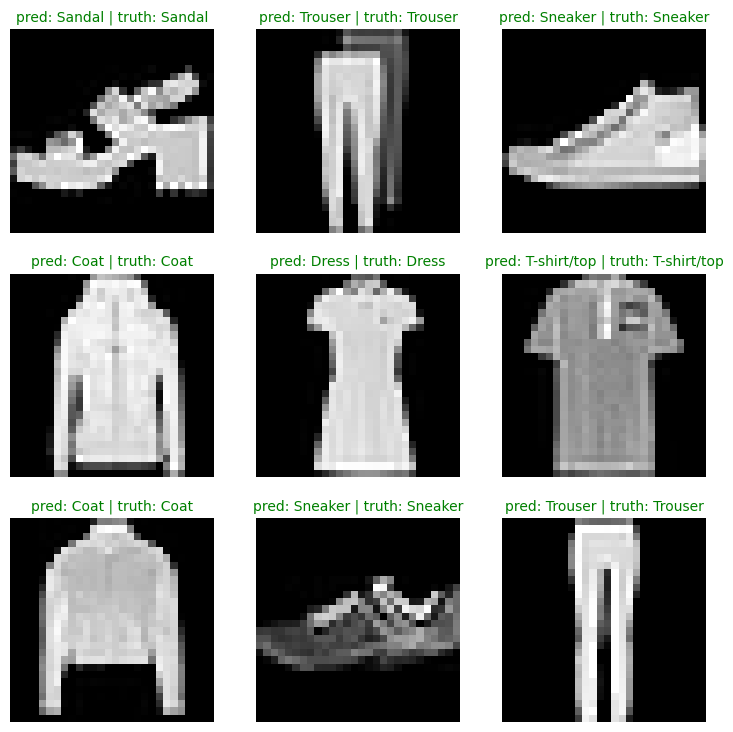

In [42]:
plt.figure(figsize=(9,9))

number_of_rows, number_of_cols = 3, 3

for index, sample in enumerate(test_samples):
    
    plt.subplot(number_of_rows, number_of_cols, index+1)
    
    plt.imshow(sample.squeeze(), cmap="gray")
    
    pred_label = class_names[pred_classes[index]]
    
    truth_label = class_names[test_label[index]]
    
    title_text = f"pred: {pred_label} | truth: {truth_label}"
    
    if pred_label == truth_label:
        plt.title(title_text, fontsize = 10, c="g")
    else:
        plt.title(title_text, fontsize = 10, c="r")
    plt.axis(False)



In [ ]:
# List to store the predictions
y_preds = []

# Set the model to evaluation mode (disables dropout, batch normalization, etc.)
model_2.eval()

# Disable gradient calculation since we're only doing inference
with torch.inference_mode():
    # Loop through the test data loader
    for X, y in test_dataloader:
        
        # Perform forward pass to get raw logits (predictions before softmax)
        y_logit = model_2(X)
        
        # Apply softmax to convert logits to probabilities, then get the predicted class
        y_pred = torch.softmax(y_logit.squeeze(), dim=1).argmax(dim=1)
        
        # Append the predicted class to the list
        y_preds.append(y_pred)

# Combine all predicted classes into a single tensor
y_pred_tensor = torch.cat(y_preds)

# Print the first 10 predicted classes to inspect
print(y_pred_tensor[:10])



tensor([9, 2, 1, 1, 6, 1, 4, 6, 5, 7])

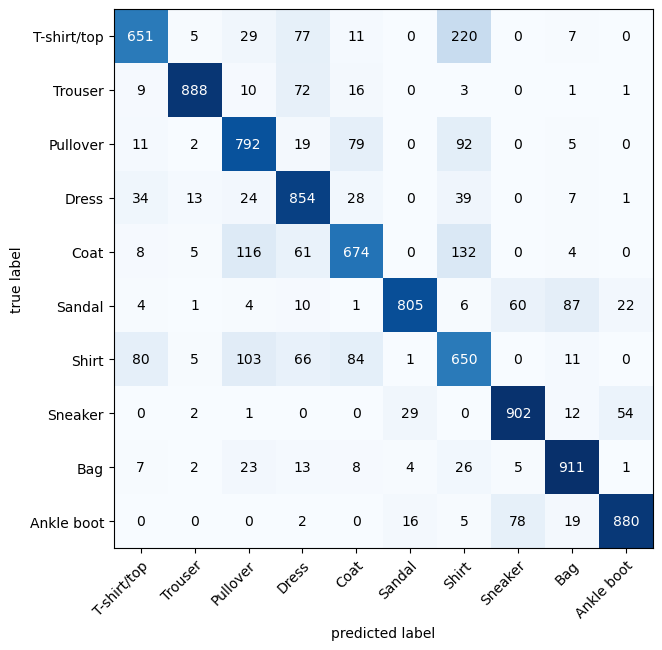

In [44]:

confmat =ConfusionMatrix(task='multiclass', num_classes=len(class_names))
confmat_tensor = confmat(preds = y_pred_tensor, target = test_data.targets)
 
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),
    class_names=class_names,
    figsize=(10,7)   
)

Based on the confusiion matrix, the model performs well with high accuracy, correctly classifying most samples, though some misclassifications occur between similar categories such as T-shirt/top vs shirt and Dress, and Pullover vs Coat and shirt. Thsi could be due to the fact that these images sometimes look similar so the model isn't accurately capturing the data

In [45]:
confmat_tensor

tensor([[651,   5,  29,  77,  11,   0, 220,   0,   7,   0],
        [  9, 888,  10,  72,  16,   0,   3,   0,   1,   1],
        [ 11,   2, 792,  19,  79,   0,  92,   0,   5,   0],
        [ 34,  13,  24, 854,  28,   0,  39,   0,   7,   1],
        [  8,   5, 116,  61, 674,   0, 132,   0,   4,   0],
        [  4,   1,   4,  10,   1, 805,   6,  60,  87,  22],
        [ 80,   5, 103,  66,  84,   1, 650,   0,  11,   0],
        [  0,   2,   1,   0,   0,  29,   0, 902,  12,  54],
        [  7,   2,  23,  13,   8,   4,  26,   5, 911,   1],
        [  0,   0,   0,   2,   0,  16,   5,  78,  19, 880]])

In [46]:
#save and load best performing model
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True,
                 exist_ok=True)

MODEL_NAME = "Fashion_MNIST_best_model.pth"
MODEL_SAVE_PATH = MODEL_PATH /MODEL_NAME

print(f"File Saving to: {MODEL_SAVE_PATH}")
torch.save(obj=model_2.state_dict(),
           f=MODEL_SAVE_PATH)


File Saving to: models/Fashion_MNIST_best_model.pth


In [47]:
#creating new instaance of model 
loaded_model_2 = FashionModel_V2(input_shape=1,
                                hidden_units=10,
                                output_shape=len(class_names))

loaded_model_2.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [48]:
loaded_model_2

FashionModel_V2(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [49]:
torch.manual_seed(42)

loaded_model_2_results = eval_model(model = loaded_model_2,
                                    data_loader=test_dataloader,
                                    loss_fn=loss_fn,
                                    accuracy_fn=accuracy_fn)

loaded_model_2_results

{'Model Name': 'FashionModel_V2',
 'Model Loss': 0.3227027952671051,
 'Model Accuracy': 88.38857827476038}

In [50]:
torch.isclose(torch.tensor(model_2_results["Model Loss"]),
              torch.tensor(loaded_model_2_results["Model Loss"]))

tensor(True)